In [2]:
! pip install --upgrade google-cloud-bigquery-storage

     |████████████████████████████████| 143 kB 5.0 MB/s eta 0:00:01


In [13]:
# The cell defines the Gerry class which does all the work
# I don't think you will need to edit this cell at all
proj_id = 'cmat-315920'
root_path = '/home/jupyter'

import google, pathlib, shutil, time, datetime, dataclasses, typing, numpy as np, pandas as pd, geopandas as gpd, networkx as nx
import matplotlib.pyplot as plt, plotly.express as px 
from shapely.ops import orient
from google.cloud import aiplatform, bigquery
from google.cloud.bigquery_storage import BigQueryReadClient, types
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

cred, proj = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient = bigquery.Client(credentials = cred, project = proj)
crs_map = 'NAD83'
crs_area = 'ESRI:102003'
crs_length = 'ESRI:102005'
# input is WKT in NAD83 - https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2020/TGRSHP2020_TechDoc_Ch3.pdf
# use ESRI:102003 for area calculations - https://epsg.io/102003
# use ESRI:102005 for length calculations - https://epsg.io/102005

def get_states():
    qry = f"""
    select
        state_fips_code as fips
        , state_postal_abbreviation as abbr
        , state_name as name
    from
        bigquery-public-data.census_utility.fips_codes_states
    """
    return bqclient.query(qry).result().to_dataframe()

@dataclasses.dataclass
class Gerry:
    # These are default values that can be overridden when you create the object
    abbr              : str
    yr                : int
    geo_simplification: float = 0.003
    min_graph_degree  : int = 1
    pop_err_max_pct   : float = 2.0
    seed              : int = 42
    overwrite         : typing.Any = False
    clr_seq           : typing.Any = tuple(px.colors.qualitative.Antique)
    # px.colors.qualitative.swatches() # shows available color schemes
    
    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    def __post_init__(self):
        self['rng'] = np.random.default_rng(self['seed'])
        self['congress'] = int((self['yr']-1786)/2)
        self['races'] = ['total', 'white', 'black', 'asian', 'hispanic', 'amerindian', 'other_race', 'two_or_more_races']
        self['race_pops'] = [f'{r}_pop' for r in self['races']]
        I = [10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 75000, 100000, 125000, 150000, 200000]
        self['income_levels'] = [f'income_less_{I[0]}'] + [f'income_{I[j]}_{I[j+1]-1}' for j in range(len(I)-1)] + [f'income_{I[-1]}_or_more']
        def rgb_to_hex(c):
            if c[0] == '#':
                return c
            else:
                return '#%02x%02x%02x' % tuple(int(rgb) for rgb in c[4:-1].split(', '))
        self['clr_seq'] = [rgb_to_hex(c) for c in self['clr_seq']]
        
        self.__dict__.update(states[states['abbr']==self['abbr']].iloc[0])
        self['run_path'] = pathlib.Path(f'{root_path}/simulations/{self["yr"]}/{self["abbr"]}')
        self['run_path'].mkdir(parents=True, exist_ok=True)
        self['files'] = {'bgs'  : self['run_path'] / 'bgs.parquet',
                         'pairs': self['run_path'] / 'pairs.parquet',
                         'graph': self['run_path'] / 'graph.gpickle',
                        }
        if self['overwrite'] is True or str(self['overwrite']).lower() == 'all':
            O = self['files'].keys()
        elif self['overwrite'] is False or self['overwrite'] is None or self['overwrite'] == '' or self['overwrite'] == []:
            O = []
        else:
            O = self['overwrite']
        for key in O:
            try:
                f = self['files'][key]
                f.unlink()
                print(f'unlinked {f}')
            except:
                print(f'No file associated to "{key}" found')

        self.get_bgs()
        return
        self['bgs'].insert(3, 'step', 0)
        self['total_pop']  = self['bgs']['total_pop'].sum()
        self['cd_names'] = np.unique(self['bgs']['cd'])
        self['cd_count'] = len(self.cd_names)
        self['pop_target'] = self.total_pop / self.cd_count
        self['pop_err_max'] =  self.total_pop * self.pop_err_max_pct / 100
        self.get_bgs()
        self.get_pairs()
        self['transit_denom'] = 100
        self.compute_stats()
        self['transit_denom'] = self['stats']['cd_transit'].sum()

    def set_dtypes(self, df):
        # does NOT work inplace
        dtypes = {'geo_id':str, 'step':np.uint16,
                  'state_fips':np.uint8, 'county_fips':np.uint8,'tract_ce':np.uint32, 'blockgroup_ce':np.uint8,
                  'cd_orig':np.uint8, 'cd':np.uint8,
                  'lon':np.float64, 'lat':np.float64, 'distance':np.float64,
                  'total_pop':np.uint32, 'cd_pop':np.uint32,
                  'area':np.float64, 'cd_area':np.float64,
                  'perim':np.float64, 'cd_perim':np.float64, 'perim_shared':np.float64, 'touch':bool,
                  'cd_polsby':np.float64, 'transit':np.float64, 'cd_transit':np.float64,
                 }
        for V in ['race_pops', 'income_levels']:
            dtypes.update({x:np.uint32 for x in self[V]})
            dtypes.update({f'cd_{x}':np.uint32 for x in self[V]})
        return df.astype({c:d for c,d in dtypes.items() if c in df.columns}, copy=False)

    def to_crs(self, df, crs):
        # works inplace
        df.to_crs(crs=crs, inplace=True)
        for c in df.columns:
            if c[:8] in ['geometry', 'centroid']:
                df[c] = df[c].to_crs(crs=crs)
        return df

    def read_data(self, variable):
        """Check if the data already exists so we can reuse it without pulling it again"""
        try:
            # Does the object already have it?
            self[variable]
        except:
            # If not, is it stored in a local file?
            print(f'Getting {variable} - ', end='')
            f = self['files'][variable]
            try:
                self[variable] = gpd.read_parquet(f)
                print(f'found {f}')
            except:
                try:
                    self[variable] = pd.read_parquet(f)
                    print(f'found {f}')
                except:
                    try:
                        self[variable] = nx.read_gpickle(f)
                        print(f'found {f}')
                    except:
                        # Nope, there's no file with that data ... gotta go get it
                        print('no local file found - compiling from source')
                        return False
        return True
    
    def find_closest(self, point, others):
        d = others.distance(point)
        return others.loc[d.idxmin()]

    def get_bgs(self):
        if self.read_data('bgs'):
            self['bgs'] = self.set_dtypes(self.to_crs(self['bgs'], crs_map))
        else:
            qry = f"""
            select
                --geo_id structure - https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
                *
            from (
                select
                    *
                from (
                    -- get shapes demographic data
                    select distinct
                        geo_id as geo_id
                        , cast(substring(geo_id, 0 , 2) as int) as state_fips
                        , cast(substring(geo_id, 3 , 3) as int) as county_fips
                        , cast(substring(geo_id, 5 , 6) as int) as tract_ce
                        , cast(substring(geo_id, 12, 1) as int) as blockgroup_ce
                        , {", ".join(self['race_pops'])}
                        , {", ".join(self['income_levels'])}
                    from
                        bigquery-public-data.census_bureau_acs.blockgroup_{self['yr']}_5yr
                    where
                        left(geo_id, 2) = "{self['fips']}"
                    ) as acs
                full outer join (
                    -- get shapes
                    select
                        geo_id as geo_id_geo
                        , blockgroup_geom as geometry
                    from
                        bigquery-public-data.geo_census_blockgroups.blockgroups_{self['fips']}
                    ) as geo
                on
                    acs.geo_id = geo.geo_id_geo
                ) as acs_geo
            full outer join (
                select
                    *
                from (
                    -- get population weighted centroids
                    -- must build geo_id because data source does not include it
                    select distinct
                        concat( 
                            lpad(cast(STATEFP as string), 2, "0"),
                            lpad(cast(COUNTYFP as string), 3, "0"),
                            lpad(cast(TRACTCE as string), 6, "0"),
                            lpad(cast(BLKGRPCE as string), 1, "0")
                            ) as geo_id_centroids
                        , LONGITUDE as lon
                        , LATITUDE as lat
                    from
                        {proj_id}.BLOCKGROUP_CENTROIDS.blockgroup_centroids_{self['fips']}
                    ) as centroids
                full outer join (
                    -- get congressional district
                    -- at block level -> must aggregate to blockgroup
                    -- 7141 (3%) of blockgroups span multiple congressional districts
                    -- We assign that entire bg to the cd with the most blocks
                    select
                        geo_id_cd
                        , cd
                    from (
                        select
                            A.*
                            , rank() over (partition by A.geo_id_cd order by A.num_blocks_in_cd desc) as r
                        from (
                            select
                                left(BLOCKID, 12) as geo_id_cd   -- remove last 4 char to get blockgroup geo_id
                                , CD{self['congress']} as cd
                                , count(*) as num_blocks_in_cd
                            from 
                                {proj_id}.Block_Equivalency_Files.{self['congress']}th_BEF
                            where
                                left(blockid, 2) = "{self['fips']}"
                            group by
                                1, 2
                            ) as A
                        ) as B
                    where
                        r = 1
                    ) as cd
                on
                    centroids.geo_id_centroids = cd.geo_id_cd
                ) as centroids_cd
            on acs_geo.geo_id = centroids_cd.geo_id_cd
            """
            bgs = bqclient.query(qry).result().to_dataframe()
            bgs['geometry'] = gpd.GeoSeries.from_wkt(bgs['geometry']).apply(lambda p: orient(p, -1))
            bgs['centroid'] = gpd.points_from_xy(bgs['lon'], bgs['lat'], crs=crs_map)
            bgs = gpd.GeoDataFrame(bgs, geometry='geometry', crs=crs_map)
            bgs['area']  = self.to_crs(bgs, crs_area).area / 1000 / 1000
            bgs['perim'] = self.to_crs(bgs, crs_length).length / 1000
            
            self.to_crs(bgs, crs_length)
            
            # fix mismatches
            cd_row_mask =   bgs['geo_id'].isnull() & ~bgs['geo_id_cd'].isnull()
            acs_row_mask = ~bgs['geo_id'].isnull() &  bgs['geo_id_cd'].isnull()
            if acs_row_mask.any() or cd_row_mask.any():
                bgs_matched = bgs[~acs_row_mask & ~cd_row_mask]
                cd_col_mask  = ~bgs[cd_row_mask] .isnull().any(axis=0)
                acs_col_mask = ~bgs[acs_row_mask].isnull().any(axis=0)
                acs_col_mask['centroid'] = False
                A = bgs.loc[acs_row_mask, acs_col_mask]
                B = bgs.loc[cd_row_mask , cd_col_mask ]
                C = A.merge(B, how='cross')
                C['match'] = C['geometry'].contains(C['centroid'])
                def f(X):
                    N = X['match'].sum()
                    if N != 1:
                        X['centroid'] = X['geometry'].centroid
                        X['cd'] = np.nan  # fill later
                    return X.nlargest(1, columns='match').drop(columns='match')
                bgs_unmatched = C.groupby('geo_id').apply(f)
                bgs = pd.concat([bgs_matched, bgs_unmatched], ignore_index=True)
        
            cd_qual = (bgs.groupby('cd')['total_pop'].transform('sum')) > 0
            others = bgs[cd_qual]
            for i, bg in bgs[~cd_qual].iterrows():
                nbr = self.find_closest(bg['centroid'], others)
                print(f"Given cd for {bg['geo_id']} is {bg['cd']} ... changing to {nbr['cd']} based on nearest neighbor {nbr['geo_id']}")
                bgs.loc[i, 'cd'] = nbr['cd']
            
            t = bgs.pop('cd')
            bgs.insert(1, 'cd_orig', t.copy())
            bgs.insert(2, 'cd', t.copy())
            self['bgs'] = self.set_dtypes(bgs.drop(columns=['geo_id_geo', 'geo_id_cd', 'geo_id_centroids']).sort_values(['cd', 'geo_id']))
#             display(self['bgs'].groupby('cd')['total_pop'].agg(['count','sum']).sort_index())
            mask = self['bgs'].isnull().any(axis=1)
            assert ~mask.any(), f"Found null values\n{self['bgs'][mask]}"
            self['bgs'].to_parquet(self['files']['bgs'], index=False)
            
            return 
            self.get_pairs()
            self.to_crs(self['bgs'], crs_map)
            self['bgs']['geometry'] = self['bgs']['geometry'].simplify(self['geo_simplification'])
            self['bgs'].to_parquet(self['files']['bgs'], index=False)

    def get_pairs(self):
        if self.read_data('pairs'):
            self['pairs'] = self.set_dtypes(self['pairs'])
        else:
            cols = ['geo_id', 'geometry', 'centroid']
            df = self.to_crs(self['bgs'], crs_length)[cols].copy()
            print(0)
            pairs = df.merge(df, how='cross').query('geo_id_x < geo_id_y')
            print(1)
            pairs['distance']     = pairs.set_geometry('centroid_x').distance(    pairs.set_geometry('centroid_y'), align=False) / 1000
            print(2)
            pairs['perim_shared'] = pairs.set_geometry('geometry_x').intersection(pairs.set_geometry('geometry_y'), align=False).length / 1000
            print(3)
            pairs['touch'] = pairs['perim_shared'] > 1e-4
            print(4)
            pairs['transit'] = pairs['distance'] / 1341 * self['rng'].uniform(0.5, 1.5)  # 50 mph → 1341 m/min
            print(5)
            self['pairs'] = self.set_dtypes(pairs.drop(columns=[c+z for c in cols[1:] for z in ['_x', '_y']]))
            print(6)
            self['pairs'].to_parquet(self['files']['pairs'], index=False)

    def edges_to_graph(self, edges):
        edge_attr=['transit']
        return nx.from_pandas_edgelist(edges, source='geo_id_x', target='geo_id_y', edge_attr=edge_attr)

    def get_graph(self):
        if self.read_data('graph'):
            pass
        else:
            edges = self['pairs'].query('touch')
            self['graph'] = self.edges_to_graph(edges)
            node_attr = ['cd', 'total_pop']
            nx.set_node_attributes(self['graph'], self['bgs'].set_index('geo_id')[node_attr].to_dict('index'))

            for cd, nodes in self['bgs'].groupby('cd')['geo_id']:
                while True:
                    H = self['graph'].subgraph(nodes)
                    components = [list(c) for c in nx.connected_components(H)]
                    if len(components) == 1:
                        break
                    print(f'CD {cd} has {len(components)} connected components ... adding edges to connect')
                    qry = f'(geo_id_x in {components[0]} & geo_id_y in {components[1]}) | (geo_id_y in {components[0]} & geo_id_x in {components[1]})'
                    cut_edges = self['pairs'].query(qry)
                    edges = self['pairs'].query(f'distance == {cut_edges["distance"].min()}')
                    self['graph'].update(self.edges_to_graph(edges))

            # ensure min degrees
            edges = list()
            for node, deg in self['graph'].degree:
                k = self['min_graph_degree'] - deg
                if k > 0:
                    print(f'{node} has degree {deg} ... adding {k} more edge(s)')
                    N = list(self['graph'].neighbors(node))
                    df = self['pairs'].query(f'(geo_id_x == {node} & geo_id_y not in {N}) | (geo_id_y == {node} & geo_id_x not in {N})')
                    edges.append(df.nsmallest(k, 'distance'))
            if len(edges) > 0:
                self['graph'].update(self.edges_to_graph(pd.concat(edges)))
            nx.write_gpickle(self['graph'], self['files']['graph'])
    
    def get_cds(self):
        return self['bgs'].groupby('cd')['geo_id'].apply(tuple).sort_index().to_dict()
    
    def get_hash(self):
        return hash(tuple(self.get_cds().items()))

    def compute_stats(self, step=None):
        if step is not None:
            self['bgs'] = self['bgs'].drop(columns=['cd','step']).merge(self['bgs_hist'].query(f'step == {step}'), on='geo_id')
        def f(nodes):
            n = nodes['geo_id'].tolist()
            edges = self['pairs'].query(f'geo_id_x in {n} & geo_id_y in {n}')
            s = {f'cd_{x}':nodes[x].sum() for x in ['area'] + self['race_pops'] + self['income_levels']}
            s.update({'step'      : nodes['step'].max(),
                      'cd_perim'  : nodes['perim'].sum() - 2 * edges['perim_shared'].sum(),
                      'cd_transit': edges['transit'].sum() / self['transit_denom']  * 100,
                     })
            s.update({'cd_polsby' : (1 - 4 * np.pi * s['cd_area'] / (s['cd_perim']**2)) * 100})
            return pd.Series(s)
        stats = self['bgs'].groupby('cd').apply(f)
        self['bgs'] = (self['bgs'].drop(columns=stats.columns, errors='ignore')
                       .merge(stats, left_on='cd', right_index=True)
                      )
        self['bgs'] = self.set_dtypes(self['bgs'].sort_values('cd'))
        self['stats'] = self.set_dtypes(stats.reset_index().sort_values('cd'))
        return self['stats']
    
    def draw_map(self, step=None):
        self.compute_stats(step)
        step = 0 if step is None else step
        df = self.to_crs(self['bgs'], crs_map).copy()
        df['cd_total_pop'] = (df['cd_total_pop'] / self['total_pop'] * 100).round(1).astype(str)
        df['cd_area'] = df['cd_area'].round(0).astype(int).astype(str)
        df['cd_transit'] = df['cd_transit'].round(1).astype(str)
        df['cd_polsby'] = df['cd_polsby'].round(1).astype(str)
        df['cd'] = df['cd'].astype(str)
        df['total_pop'] = df['total_pop'].round(0).astype(int).astype(str)
        df['area'] = df['area'].round(0).astype(int).astype(str)
        df['cd_stats'] = df['cd']+': pop='+df['cd_total_pop']+'%, area='+df['cd_area']+', tt='+df['cd_transit']+', pp='+df['cd_polsby']
        fig = px.choropleth(df,
                            geojson = df['geometry'],
                            locations = df.index,
                            color = "cd_stats",
                            color_discrete_sequence = self['clr_seq'],
                            hover_data = ['area', 'total_pop', 'lon', 'lat'],
                           )
        fig.update_geos(fitbounds="locations", visible=True)
        fig.update_layout({
            'title'  : {'text':f'{self["name"]} {self["yr"]} step {step}', 'x':0.5, 'y':1.0},
            'margin' : {'r':0, 't':20, 'l':0, 'b':0},
            'legend' : {'y':0.5},
        })
        fig.show()

    def draw_graph(self, step=None, layout=nx.spring_layout):
        self.get_graph()
        self.compute_stats(step)
        pos = layout(self['graph'])
        for cd, nodes in self['bgs'].groupby('cd')['geo_id']:
            H = self['graph'].subgraph(nodes)
            nx.draw_networkx_nodes(H, pos=pos, node_size=10, node_color=self['clr_seq'][cd-1])
        nx.draw_networkx_edges(self['graph'], pos=pos)
        plt.show()

    def check_pop_balance(self, T):
        comp = nx.connected_components(T)
        next(comp)
        s = sum(T.nodes[n]['total_pop'] for n in next(comp))
        return abs(s - self.pop_target) <= self.pop_err_max
        
    def recom_step(self):
        self.get_graph()
        self['bgs'].set_index('geo_id', inplace=True)
        recom_found = False
        attempts = 0
        for curr in self['rng'].permutation([(a,b) for a in self.cd_names for b in self.cd_names if a < b]).tolist():
            nodes = self['bgs'].query(f'cd in {curr}').copy()
            H = self['graph'].subgraph(nodes.index)
            trees = []
            for i in range(1000):
                w = {e: self['rng'].uniform() for e in H.edges}
                nx.set_edge_attributes(H, w, "weight")
                T = nx.minimum_spanning_tree(H, "weight")
                h = hash(tuple(sorted(T.edges)))
                if h not in trees:
                    trees.append(h)
                    for e in self['rng'].permutation(T.edges):
                        attempts += 1
                        T.remove_edge(*e)
                        if self.check_pop_balance(T):
                            recom_found = True
                            new = [list(c) for c in nx.connected_components(T)]
                            nodes['cd_new'] = 0
                            for n, c in zip(new, curr):
                                nodes.loc[n, 'cd_new'] = c
                            i = nodes.groupby(['cd','cd_new'])['area'].sum().idxmax()
                            if i[0] != i[1]:
                                new[0], new[1] = new[1], new[0]
                            for n, c in zip(new, curr):
                                self['bgs'].loc[n, 'cd'] = c
                            break
                        T.add_edge(*e)
                else:
                    print('Got a repeat spanning tree')
                if recom_found:
                    break
            if recom_found:
                break
        self['bgs'].reset_index(inplace=True)
        assert recom_found, "No suitable recomb step found"
        return recom_found, attempts, trees
        
    def record(self, concat=False):
        self.compute_stats()
        record_cols = {'stats':['step','cd','cd_total_pop','cd_area','cd_polsby','cd_transit'],
                       'bgs'  :['step','cd','geo_id']}
        for X, cols in record_cols.items():
            H = f'{X}_hist'
            if concat:
                self[H] = self.set_dtypes(pd.concat(self[H], ignore_index=True)[cols])
                self[H].to_parquet(self['files']['run'] / f'{X}_hist.parquet', index=False)
            else:
                df = self.set_dtypes(self[X][cols])
                try:
                    self[H].append(df)
                except:
                    self[H] = [df]

    def run_mcmc(self, steps=10, update_period=5):
        def g(t):
            hours, t = divmod(t, 60*60)
            minutes, seconds = divmod(t, 60)
            return f'{int(hours)}:{int(minutes)}:{seconds:.1f}'
        
        self.record()
        start = time.perf_counter()
        for step in range(1, steps+1):
            self['bgs']['step'] = step
            success, attempts, trees = self.recom_step()
            self.record()
            if step % update_period == 0:
                stop = time.perf_counter()
                elapsed = stop - start
                total = elapsed / step * steps
                remain = total - elapsed
                print(f"I've done {step} steps in {g(elapsed)}; time remaining {g(remain)} (est)")

        self['files']['run'] = self['run_path'] / f'runs/{datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}'
        self['files']['run'].mkdir(parents=True, exist_ok=True)
        self.record(concat=True)
        self['steps'] = np.unique(self['bgs_hist']['step'])
        
    def read_prior(self, before_most_recent=0):
        path = sorted((g['run_path'] / 'runs').iterdir(), reverse=True)[before_most_recent]
        for X in ['bgs_hist', 'stats_hist']:
            self[X] = pd.read_parquet(path / f'{X}.parquet')
        self['steps'] = np.unique(self['bgs_hist']['step'])

<AxesSubplot:>

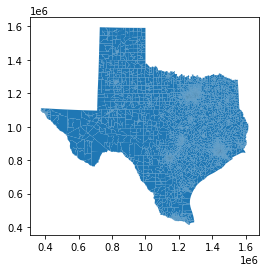

In [10]:
vtds = gpd.read_file("/home/jupyter/TX_VTD/")
vtds.plot()


In [14]:
# Create Gerry object
# Looks for local saved copies of bgs, pairs, and graph (fast) unless otherwise specified in overwrite
# Anything not found is compiled from source (slow)
# clr_seq = color scheme ... see last cell for other options
# pop_err_max_pct = maximum allowed departure of any cd from perfect population balance

# geo_simplification determines how aggressively the polygons are smoothed - changes will not take effect until existing 'bgs' file is overwritten/deleted
# min_graph_degree = smallest allowed number of neighbors for each bg; assigns nearest non-adjacent neighbors if not enough - - changes will not take effect until existing 'graph' file is overwritten/deleted
# overwrite = which of 'bgs', 'pairs', and 'graph' to overwrite and recompile from source


states = get_states()
states
for i, state in states.iterrows():
    if state['abbr'] == 'TX':
        display(state['name'])
        g = Gerry(abbr=state['abbr'],
                  yr=2017,
                  clr_seq=px.colors.qualitative.Antique,
                  pop_err_max_pct=0.8,
                  geo_simplification=0.003,
                  min_graph_degree=1,
                  overwrite=['bgs'],
                  seed=30,
                 )
#     #     g.get_graph()

'Texas'

No file associated to "bgs" found
Getting bgs - no local file found - compiling from source


In [11]:
g['bgs'].plot()

NameError: name 'g' is not defined

In [20]:
vtds.head()

,CNTY,COLOR,VTD,CNTYVTD,VTDKEY,Shape_area,Shape_len,geometry
0,1,7,0001,10001,1,5.616316e+06,15020.544212,"POLYGON ((1413960.808 1073012.816, 1413971.571..."
1,1,7,0002,10002,2,2.562133e+08,94432.828741,"POLYGON ((1420165.429 1066385.797, 1420251.968..."
2,1,4,0003,10003,3,7.084692e+07,55277.408984,"POLYGON ((1416275.023 1072178.732, 1416410.201..."
3,1,5,0004,10004,4,2.411696e+08,91313.172999,"POLYGON ((1435604.819 1074650.256, 1435674.876..."
4,1,3,0005,10005,5,1.689853e+08,86938.248879,"POLYGON ((1436888.342 1072498.734, 1436911.364..."


In [23]:
g.bgs.shape, vtds.shape
15838*9190, 15838**2, 15838*15837/2
A = g.bgs[['geo_id', 'geometry']].to_crs(crs_area)
B = vtds[['CNTYVTD', 'geometry']].to_crs(crs_area)
C = A.merge(B, how='cross')

MemoryError: Unable to allocate 1.08 GiB for an array with shape (1, 145551220) and data type object

In [ ]:
C = c.iloc[:20]
C['area'] = C['geometry_x'].intersection(C['geometry_y']).area
C['intersects'] = C['area'] > 0.00001
D = C.groupby('geo_id')['intersects'].sum()
D.sort_values()

In [ ]:
A.int

In [22]:
vtds['VTDKEY'].value_counts().sort_values()

2049    1
6163    1
4114    1
2065    1
4122    1
       ..
4086    1
2039    1
8188    1
4078    1
2047    1
Name: VTDKEY, Length: 9190, dtype: int64

In [8]:
g.draw_map()


NameError: name 'g' is not defined

In [ ]:
# Run recom MCMC for specified number of steps, reporting progress every "update_period" steps
# results save to timestamped file in /home/jupyter/simulations/yr/state/runs
steps = 4
g.run_mcmc(steps=steps, update_period=2)

In [ ]:
# Read saved MCMC runs
# "before_most_recent" = how far back to go .. 0=most recent run, 1=run before that, 2=run before that, ...
g.read_prior(before_most_recent=0)
for step in g['steps'][::1]:
    g.draw_map(step)

In [ ]:
px.colors.qualitative.swatches()